In [1]:
%reset -sf

import tensorflow as tf
import tensorflow_probability as tfp
print("Tensorflow:", tf.__version__)
print("Tensorflow Probability", tfp.__version__)


# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Instead of enabling memory growth, set a memory limit
        memory_limit = 16_376 # Set the memory limit in MB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
        )
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2024-09-18 06:47:18.762666: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-18 06:47:18.785015: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1
1 Physical GPUs, 1 Logical GPU


2024-09-18 06:47:19.897408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16376 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [2]:
import sys
import os
import glob

HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH + "/qe")

import get_data as gd
import atlas_plot as ap

plot = ap.Plotter()

# INN packages
from flow import *
from utils import *

import pandas as pd
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
import matplotlib as mpl
import shap

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [3]:
from dataclasses import dataclass

data_path = "/root/data/full_345324_data.h5"


def pt(px, py):
    return np.sqrt(np.square(px) + np.square(py))


def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))


def phi(px, py):
    return np.arctan2(py, px)

def m(p4):
    return np.sqrt(np.square(p4[:, 3]) - np.square(p4[:, 0]) - np.square(p4[:, 1]) - np.square(p4[:, 2]))

@dataclass
class Lead_lep:
    px = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPx"] * GEV
    py = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPy"] * GEV
    pz = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPz"] * GEV
    energy = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepE"] * GEV
    pt = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPt"] * GEV
    eta = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepEta"]
    phi = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Sublead_lep:
    px = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPx"] * GEV
    py = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPy"] * GEV
    pz = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPz"] * GEV
    energy = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepE"] * GEV
    pt = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPt"] * GEV
    eta = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepEta"]
    phi = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T

@dataclass
class Dilep:
    lead = Lead_lep()
    sublead = Sublead_lep()
    p4 = Lead_lep.p4 + Sublead_lep.p4
    p3 = p4[:, :3]
    px = p4[:, 0]
    py = p4[:, 1]
    pz = p4[:, 2]
    energy = p4[:, 3]
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    m = m(p4)

@dataclass
class Met:
    px = pd.read_hdf(data_path, "reco_met")["RecoMETPx"] * GEV
    py = pd.read_hdf(data_path, "reco_met")["RecoMETPy"] * GEV
    phi = pd.read_hdf(data_path, "reco_met")["RecoMETPhi"]
    pt = pt(px, py)


@dataclass
class Truth_lead_lep:
    px = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPx"] * GEV
    py = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPy"] * GEV
    pz = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPz"] * GEV
    energy = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepE"] * GEV
    pt = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPt"] * GEV
    eta = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepEta"]
    phi = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_sublead_lep:
    px = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPx"] * GEV
    py = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPy"] * GEV
    pz = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPz"] * GEV
    energy = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepE"] * GEV
    pt = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPt"] * GEV
    eta = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepEta"]
    phi = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T

@dataclass
class Truth_dilep:
    lead = Truth_lead_lep()
    sublead = Truth_sublead_lep()
    p4 = Lead_lep.p4 + Sublead_lep.p4
    p3 = p4[:, :3]
    px = p4[:, 0]
    py = p4[:, 1]
    pz = p4[:, 2]
    energy = p4[:, 3]
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    m = m(p4)

@dataclass
class Truth_met:
    px = pd.read_hdf(data_path, "truth_met")["TruthRecoMETPx"] * GEV
    py = pd.read_hdf(data_path, "truth_met")["TruthRecoMETPy"] * GEV
    phi = pd.read_hdf(data_path, "truth_met")["TruthRecoMETPhi"]
    pt = pt(px, py)


@dataclass
class Lead_w:
    px = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPx"] * GEV
    py = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPy"] * GEV
    pz = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPz"] * GEV
    energy = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWE"] * GEV
    pt = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPt"] * GEV
    eta = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWEta"]
    phi = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPhi"]
    m = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWM"] * GEV
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Sublead_w:
    px = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPx"] * GEV
    py = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPy"] * GEV
    pz = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPz"] * GEV
    energy = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWE"] * GEV
    pt = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPt"] * GEV
    eta = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWEta"]
    phi = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPhi"]
    m = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWM"] * GEV
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T

In [4]:
# reco
lead_lep = Lead_lep()
sublead_lep = Sublead_lep()
dilep = Dilep()
met = Met()

# truth
truth_lead_lep = Truth_lead_lep()
truth_sublead_lep = Truth_sublead_lep()
Truth_dilep = Truth_dilep()
truth_met = Truth_met()

# target Ws
w_lead = Lead_w()
w_sublead = Sublead_w()

In [5]:
## Global variables

GEV = 1e3

# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > 22
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > 15
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > 10
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > 20
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

665
86425
17938
30738
123678


In [6]:
## Observing variables

obs_kin = np.column_stack(
    (
        lead_lep.px,
        lead_lep.py,
        lead_lep.pz,
        lead_lep.energy,
        lead_lep.pt,
        lead_lep.eta,
        lead_lep.phi,
        sublead_lep.px,
        sublead_lep.py,
        sublead_lep.pz,
        sublead_lep.energy,
        sublead_lep.pt,
        sublead_lep.eta,
        sublead_lep.phi,
        met.px,
        met.py,
        met.pt,
        met.phi,
        dilep.px,
        dilep.py,
        dilep.pz,
        dilep.energy,
        dilep.pt,
        dilep.eta,
        dilep.phi,
        dilep.m,
    )
)[PRE_CUT]

# Kinematics of observing variables (inputs for training)
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array
ROBUST_OBS = RobustScaler()
obs_kin = ROBUST_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (234337, 26)
<class 'numpy.ndarray'>


In [ ]:
# TODO: test robust scaler

In [7]:
## Interesting variables

w_lead_p4 = pd.DataFrame(w_lead.p4[PRE_CUT])
w_sublead_p4 = pd.DataFrame(w_sublead.p4[PRE_CUT])

# Kinematics of interesting variables (target for training)
int_kin = np.concatenate([w_lead_p4, w_sublead_p4], axis=-1)
print("int_kin shape:", int_kin.shape)
# int_kin = int_kin.to_numpy()  # convert to numpy array
print(type(int_kin))

int_kin shape: (234337, 8)
<class 'numpy.ndarray'>


In [8]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.9,
    test_size=0.1,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

X (Interest)
Training data shape: (210903, 26);
Validing data shape: (11717, 26);
Testing data shape: (11717, 26).
Y (Observed)
Training data shape: (210903, 8);
Validing data shape: (11717, 8);
Testing data shape: (11717, 8).


In [157]:
# Define a new activation function


# training variables

BATCH_SIZE = 16384
EPOCHS = 1_024
LEARNING_RATE = 1e-6


# Define a new activation function
def custom_activation(x):
    return (0.73 - (-0.27)) * (tf.tanh(x) + 1) / 2 + (-0.27)

class EPConstraint(tf.keras.constraints.Constraint):
    def __call__(self, w):
        # Ensure that energy-momentum are time-like case
        lead_px = w[:, 0]
        lead_py = w[:, 1]
        lead_pz = w[:, 2]
        lead_energy = w[:, 3]
        # sublead_px = w[:, 4]
        # sublead_py = w[:, 5]
        # sublead_pz = w[:, 6]
        # sublead_energy = w[:, 7]

        # Calculate the constraint
        lead_constraint = tf.maximum(
            0.0, lead_energy**2 - lead_px**2 - lead_py**2 - lead_pz**2
        )
        # sublead_constraint = tf.maximum(
        #     0.0, sublead_energy**2 - sublead_px**2 - sublead_py**2 - sublead_pz**2
        # )
        # Create a mask for invalid four-vectors (constraint == 0)
        lead_mask = tf.cast(tf.not_equal(lead_constraint, 0.0), w.dtype)
        # sublead_mask = tf.cast(tf.not_equal(sublead_constraint, 0.0), w.dtype)
        # If constraint is zero, set the entire four-vector to zero
        adjusted_w = (
            w
            * tf.expand_dims(lead_mask, axis=-1)
            # * tf.expand_dims(sublead_mask, axis=-1)
        )
        return adjusted_w

# Register the custom activation and constraint
tf.keras.utils.get_custom_objects().update(
    {
        "EPConstraint": EPConstraint,
    }
)

# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden layers
    for _ in range(2):
        x = tf.keras.layers.Dense(units=8192, activation="selu")(x)
        x = tf.keras.layers.Dropout(rate=0.1)(x)
        x = tf.keras.layers.Dense(units=8192, activation="selu")(x)
        x = tf.keras.layers.Dropout(rate=0.1)(x)
        
    
    # seperate for individual lead and sublead
    x_lead = tf.keras.layers.Dense(units=512, activation="selu")(x)
    for _ in range(4):
        x_lead = tf.keras.layers.Dense(units=2048, activation="selu")(x_lead)
    x_sublead = tf.keras.layers.Dense(units=512, activation="selu")(x)
    for _ in range(4):
        x_lead = tf.keras.layers.Dense(units=2048, activation="selu")(x_lead)
    x_sublead = tf.keras.layers.Dense(units=512, activation="selu")(x_sublead)

    # Output layers
    outputs_lead = tf.keras.layers.Dense(units=4, activation="linear", name="lead")(x_lead)
    outputs_sublead = tf.keras.layers.Dense(units=4, activation="linear", name="sublead")(x_sublead)
    
    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=[outputs_lead, outputs_sublead])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss={
            'lead': tf.keras.losses.MeanAbsoluteError(),
            'sublead': tf.keras.losses.MeanAbsoluteError()
        },
    )

    return model

In [158]:
model = build_model()
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 26)        │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 8192)      │    221,184 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8192)      │          0 │ dense_70[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 8192)      │ 67,117,056 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8192)      │          0 │ dense_71[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 8192)      │ 67,117,056 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 8192)      │          0 │ dense_72[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 8192)      │ 67,117,056 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 8192)      │          0 │ dense_73[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_74 (Dense)    │ (None, 512)       │  4,194,816 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_75 (Dense)    │ (None, 2048)      │  1,050,624 │ dense_74[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_76 (Dense)    │ (None, 2048)      │  4,196,352 │ dense_75[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_77 (Dense)    │ (None, 2048)      │  4,196,352 │ dense_76[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_78 (Dense)    │ (None, 2048)      │  4,196,352 │ dense_77[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 2048)      │  4,196,352 │ dense_78[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 2048)      │  4,196,352 │ dense_80[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_82 (Dense)    │ (None, 2048)      │  4,196,352 │ dense_81[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 512)       │  4,194,816 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 2048)      │  4,196,352 │ dense_82[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 512)       │    262,656 │ dense_79[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead (Dense)        │ (None, 4)         │      8,196 │ dense_83[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sublead (Dense)     │ (None, 4)         │      2,052 │ dense_84[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 240,659,976 (918.04 MB)

 Trainable params: 240,659,976 (918.04 MB)

 Non-trainable params: 0 (0.00 B)

In [159]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=16,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

def scheduler(epoch, lr):
    if epoch < 512:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.0001))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit the model
history = model.fit(
    x=train_x,
    y=(train_y[:, :4], train_y[:, 4:]),
    validation_data=(valid_x, (valid_y[:, :4], valid_y[:, 4:])),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    callbacks=[stop_early, lr_scheduler],
)

Epoch 1/1024


I0000 00:00:1726644360.278911  186935 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 36 bytes spill stores, 36 bytes spill loads

I0000 00:00:1726644367.518973  652513 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3078', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1726644367.557108  652529 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2807', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1726644367.717008  652504 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3078', 420 bytes spill stores, 416 bytes spill loads

I0000 00:00:1726644367.831408  652530 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2807', 420 bytes spill stores, 416 bytes spill loads

I0000 00:00:1726644370.

13/13 - 16s - 1s/step - lead_loss: 81.4199 - loss: 134.3706 - sublead_loss: 52.9480 - val_lead_loss: 79.5205 - val_loss: 131.6708 - val_sublead_loss: 52.1503 - learning_rate: 1.0000e-06
Epoch 2/1024
13/13 - 7s - 507ms/step - lead_loss: 79.0203 - loss: 131.0526 - sublead_loss: 52.0153 - val_lead_loss: 77.1127 - val_loss: 128.2925 - val_sublead_loss: 51.1798 - learning_rate: 1.0000e-06
Epoch 3/1024
13/13 - 7s - 511ms/step - lead_loss: 76.8504 - loss: 127.9448 - sublead_loss: 51.0923 - val_lead_loss: 74.9182 - val_loss: 125.1620 - val_sublead_loss: 50.2438 - learning_rate: 1.0000e-06
Epoch 4/1024
13/13 - 7s - 510ms/step - lead_loss: 74.7439 - loss: 124.9575 - sublead_loss: 50.2019 - val_lead_loss: 72.8324 - val_loss: 122.1957 - val_sublead_loss: 49.3633 - learning_rate: 1.0000e-06
Epoch 5/1024
13/13 - 7s - 507ms/step - lead_loss: 72.7035 - loss: 122.0666 - sublead_loss: 49.3439 - val_lead_loss: 70.8460 - val_loss: 119.3786 - val_sublead_loss: 48.5326 - learning_rate: 1.0000e-06
Epoch 6/10

In [160]:
# Make a directory
dir_name = HOME_PATH + "/6th_trial/reco_w_combined_result/"
name = "dnn_reco_w_combined"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")

# save modela
model.save(dir_name + name + ".keras", save_format="keras", overwrite=True)

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

Directory /root/work/QE-mls/6th_trial/reco_w_combined_result/ cleaned.
Directory /root/work/QE-mls/6th_trial/reco_w_combined_result/ exists.
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


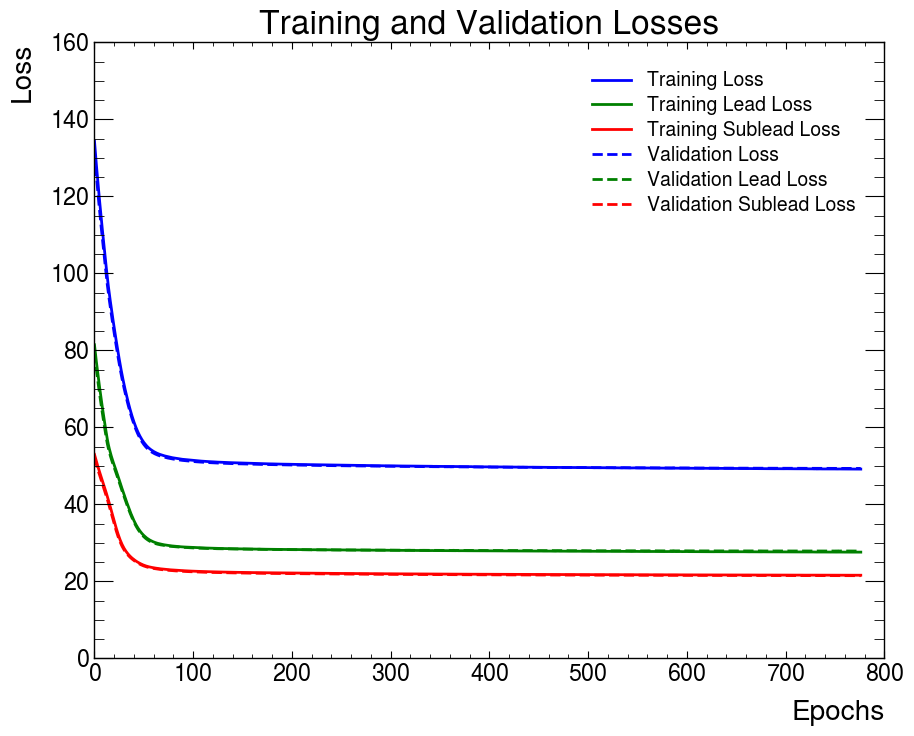

In [161]:
# Extract loss values
loss = history.history['loss']
lead_loss = history.history['lead_loss']
sublead_loss = history.history['sublead_loss']
val_loss = history.history['val_loss']
val_lead_loss = history.history['val_lead_loss']
val_sublead_loss = history.history['val_sublead_loss']

# Define colors for each metric
colors = {
    'loss': 'blue',
    'lead_loss': 'green',
    'sublead_loss': 'red',
    'val_loss': 'blue',
    'val_lead_loss': 'green',
    'val_sublead_loss': 'red'
}

# Plot training and validation losses
plt.figure(figsize=(10, 8))

plt.plot(loss, label='Training Loss', color=colors['loss'])
plt.plot(lead_loss, label='Training Lead Loss', color=colors['lead_loss'])
plt.plot(sublead_loss, label='Training Sublead Loss', color=colors['sublead_loss'])
plt.plot(val_loss, label='Validation Loss', linestyle='dashed', color=colors['val_loss'])
plt.plot(val_lead_loss, label='Validation Lead Loss', linestyle='dashed', color=colors['val_lead_loss'])
plt.plot(val_sublead_loss, label='Validation Sublead Loss', linestyle='dashed', color=colors['val_sublead_loss'])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(False)
plt.show()

In [162]:
# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz",
    pred_y=sig_pred.reshape(sig_truth.shape),
    test_y=sig_truth,
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

Truth mean: -0.564, std: 39.611, min: -409.337, max: 481.755


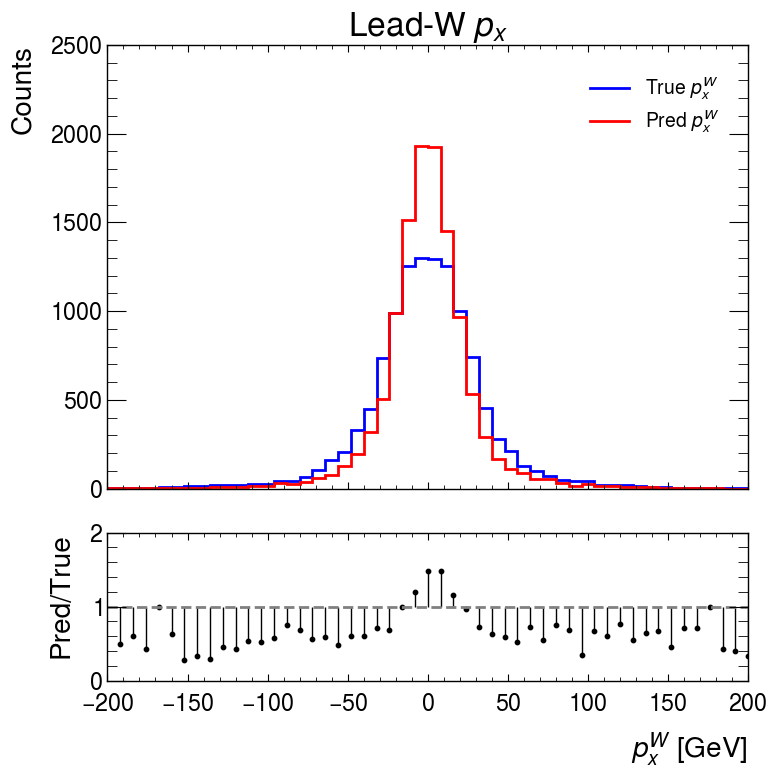

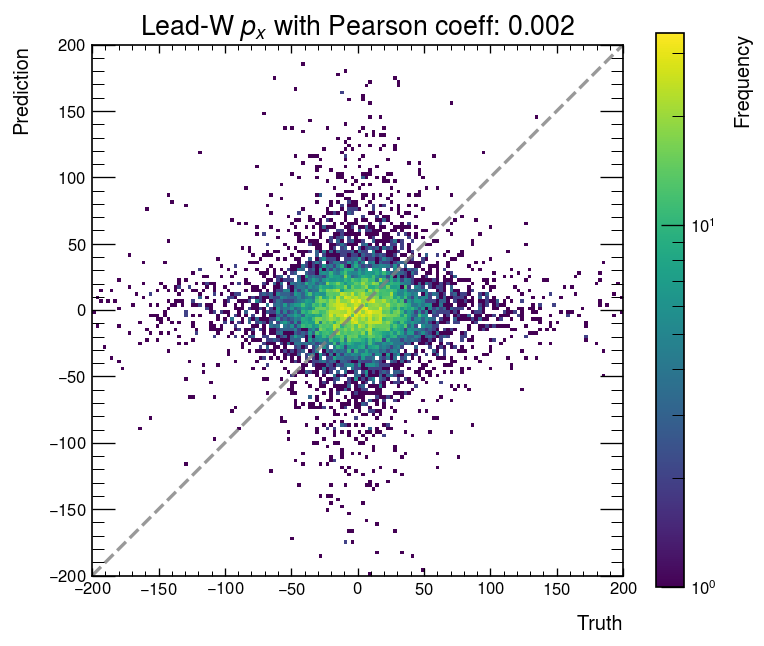

In [163]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 0], sig_pred_inv[:, 0]],
    label=r"$p_{x}^{W}$",
    title="Lead-W $p_{x}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 0],
    sig_pred_inv[:, 0],
    r"Lead-W $p_{x}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,0], sig_pred_inv[:,0])[0]:.3f}",
    range=set_range,
)

Truth mean: -0.091, std: 28.056, min: -234.187, max: 269.844


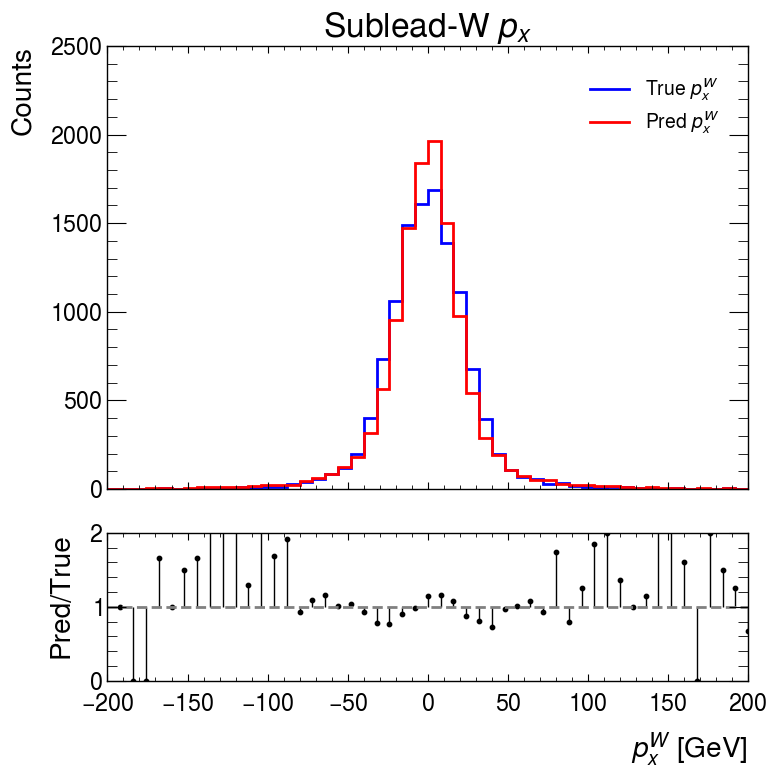

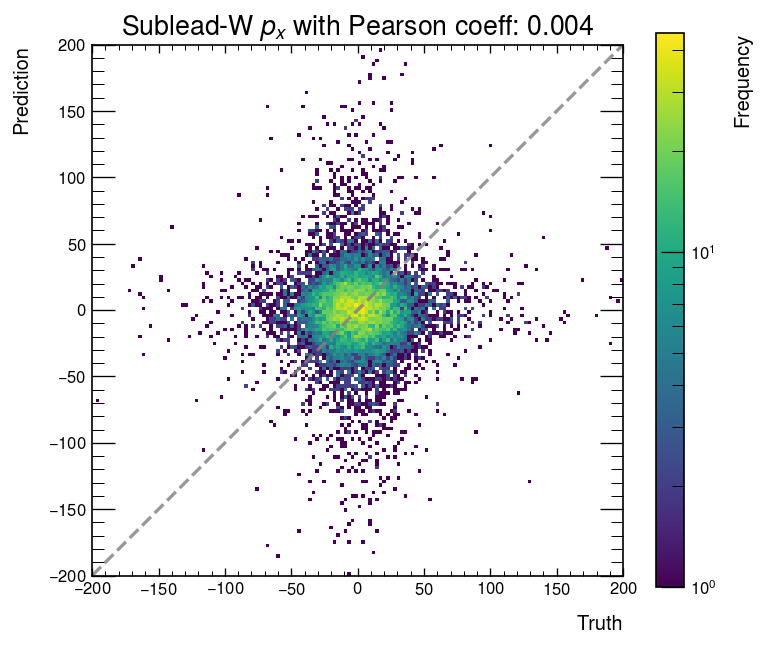

In [164]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,4]):.3f}, std: {np.std(sig_truth_inv[:,4]):.3f}, min: {np.min(sig_truth_inv[:,4]):.3f}, max: {np.max(sig_truth_inv[:,4]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 4], sig_pred_inv[:, 4]],
    label=r"$p_{x}^{W}$",
    title="Sublead-W $p_{x}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 4],
    sig_pred_inv[:, 4],
    r"Sublead-W $p_{x}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,4], sig_pred_inv[:,4])[0]:.3f}",
    range=set_range,
)

Truth mean: 0.199, std: 39.589, min: -364.231, max: 431.745


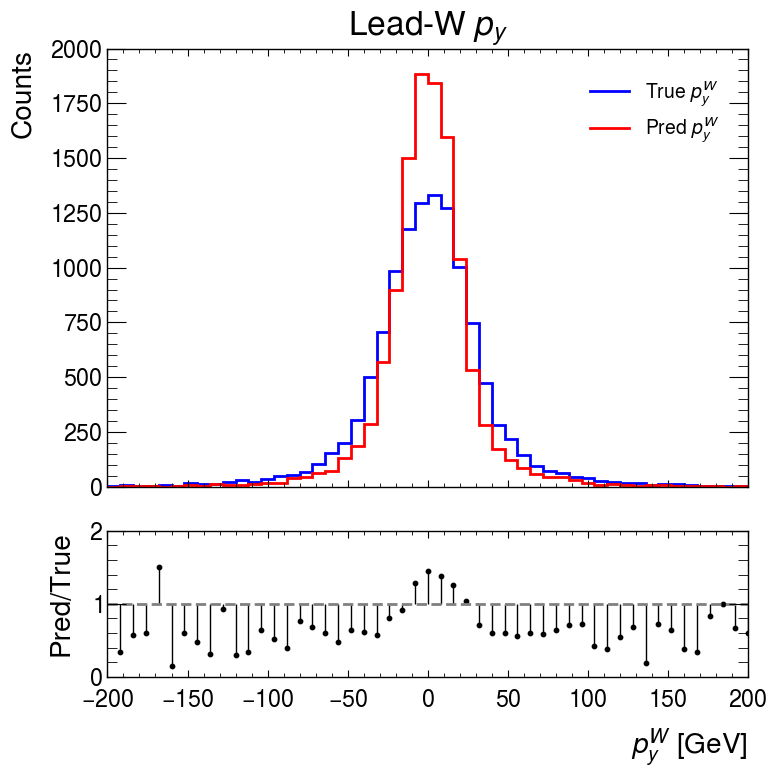

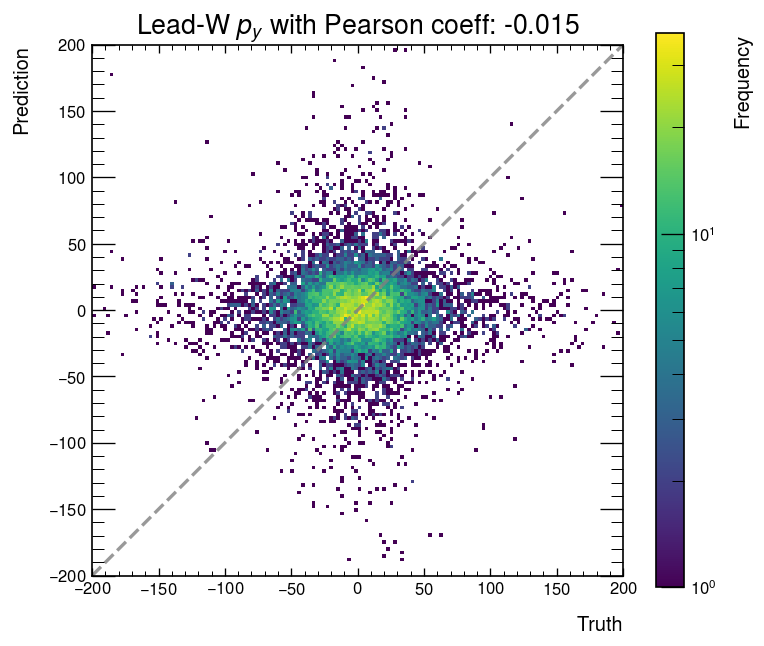

In [165]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{y}^{W}$",
    title="Lead-W $p_{y}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"Lead-W $p_{y}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,1], sig_pred_inv[:,1])[0]:.3f}",
    range=set_range,
)

Truth mean: 0.336, std: 27.389, min: -348.514, max: 402.986


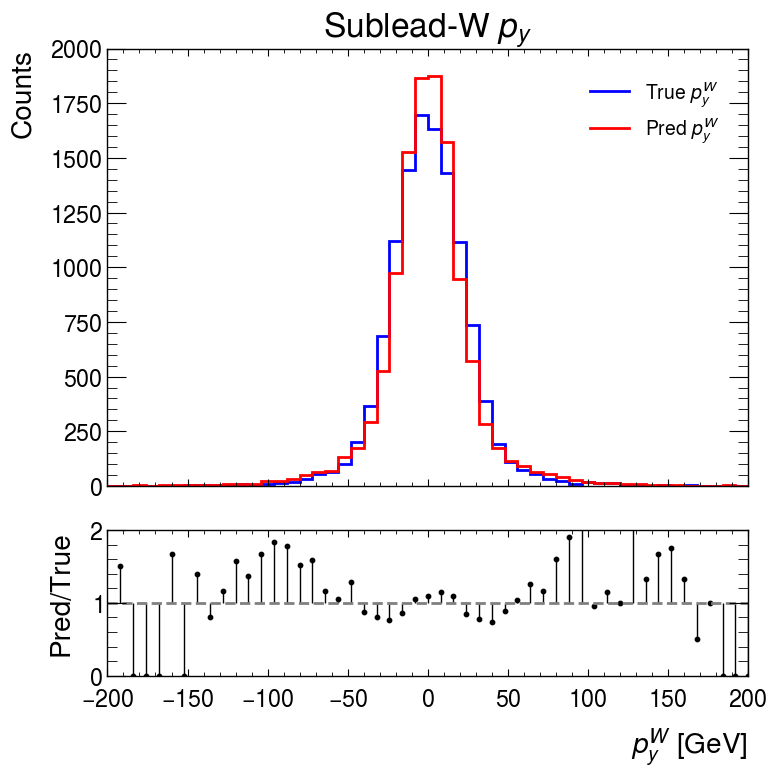

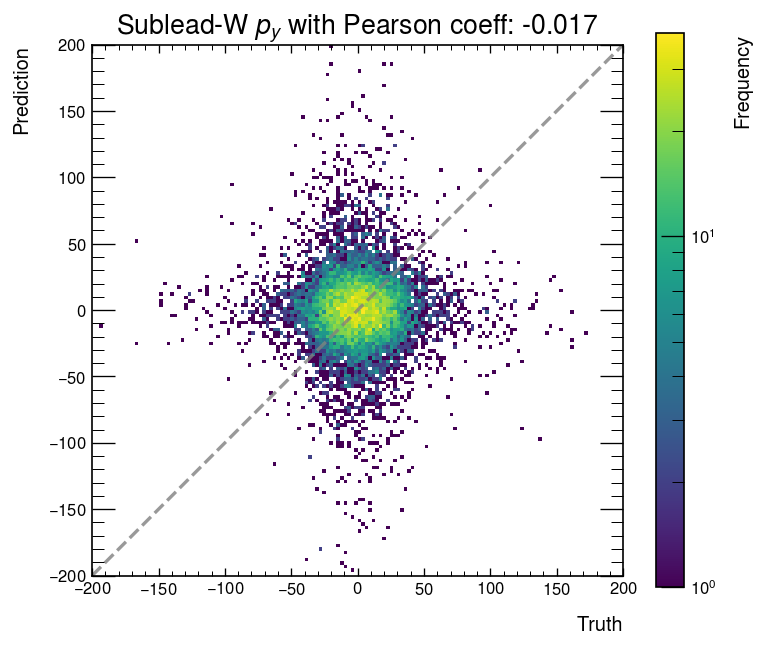

In [166]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,5]):.3f}, std: {np.std(sig_truth_inv[:,5]):.3f}, min: {np.min(sig_truth_inv[:,5]):.3f}, max: {np.max(sig_truth_inv[:,5]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 5], sig_pred_inv[:, 5]],
    label=r"$p_{y}^{W}$",
    title="Sublead-W $p_{y}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,5], sig_pred_inv[:,5])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 5],
    sig_pred_inv[:, 5],
    r"Sublead-W $p_{y}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,5], sig_pred_inv[:,5])[0]:.3f}",
    range=set_range,
)

Truth mean: -2.816, std: 175.934, min: -1046.195, max: 1674.743


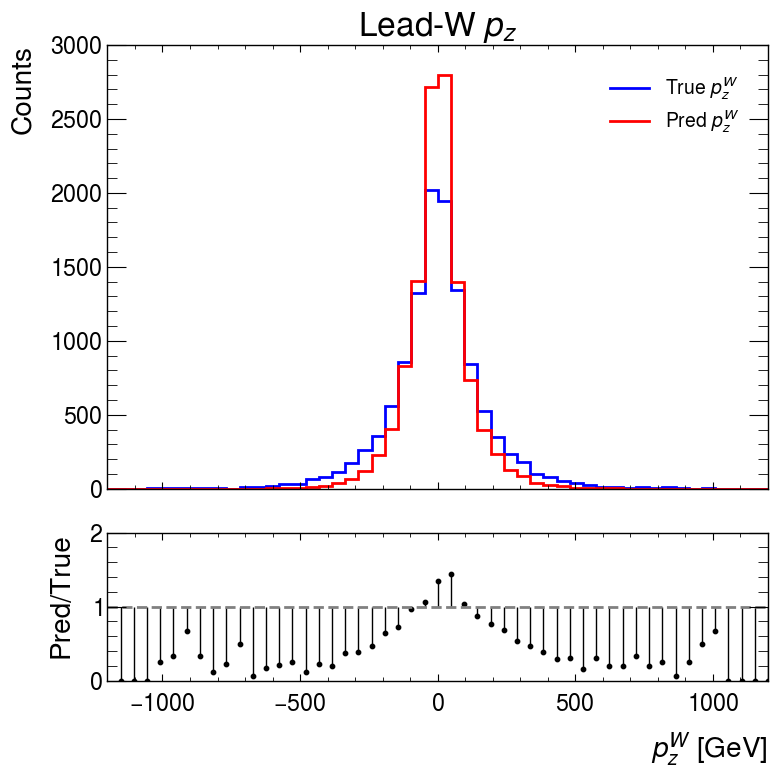

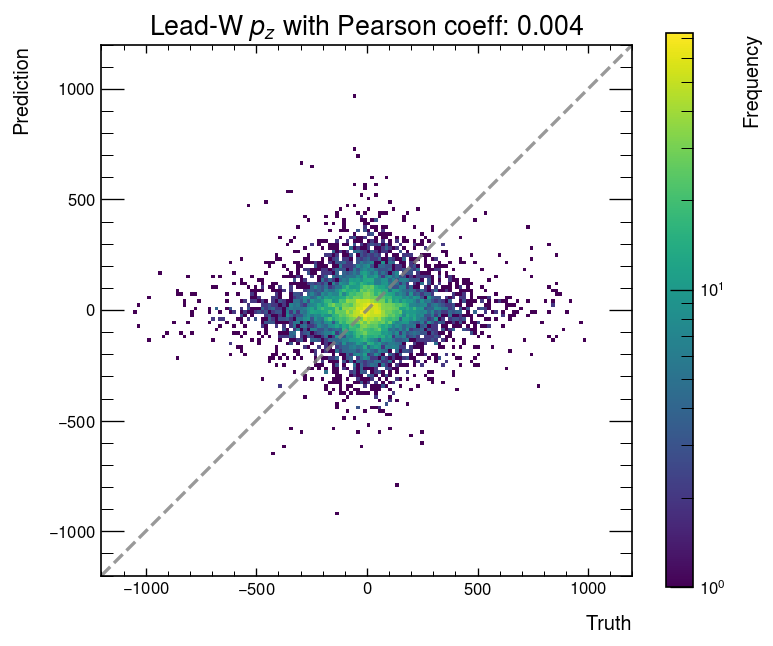

In [167]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-1200, 1200]

plot.hist(
    data=[sig_truth_inv[:, 2], sig_pred_inv[:, 2]],
    label=r"$p_{z}^{W}$",
    title="Lead-W $p_{z}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 2],
    sig_pred_inv[:, 2],
    r"Lead-W $p_{z}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,2], sig_pred_inv[:,2])[0]:.3f}",
    range=set_range,
)

Truth mean: -2.421, std: 115.216, min: -1282.205, max: 914.444


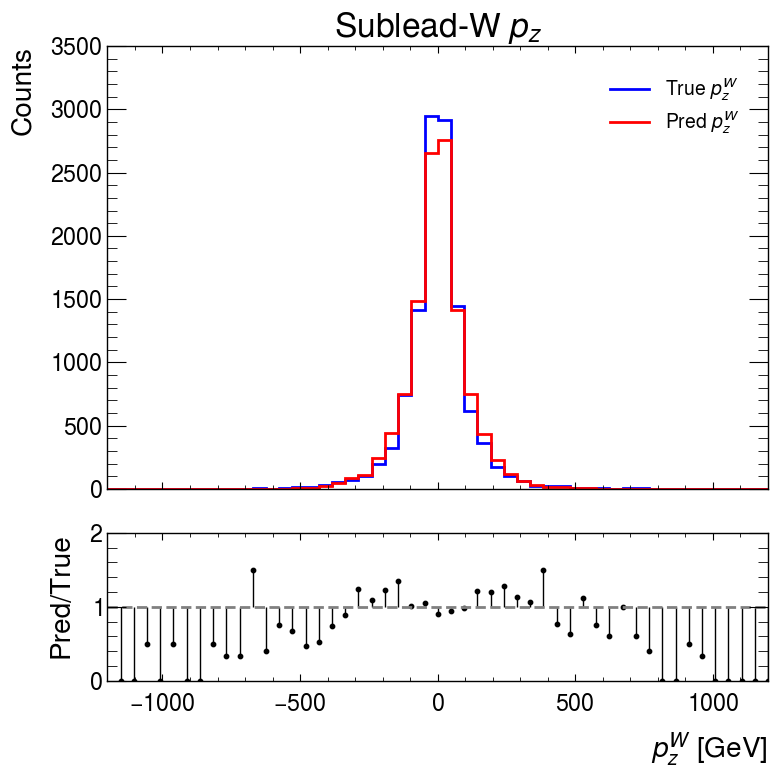

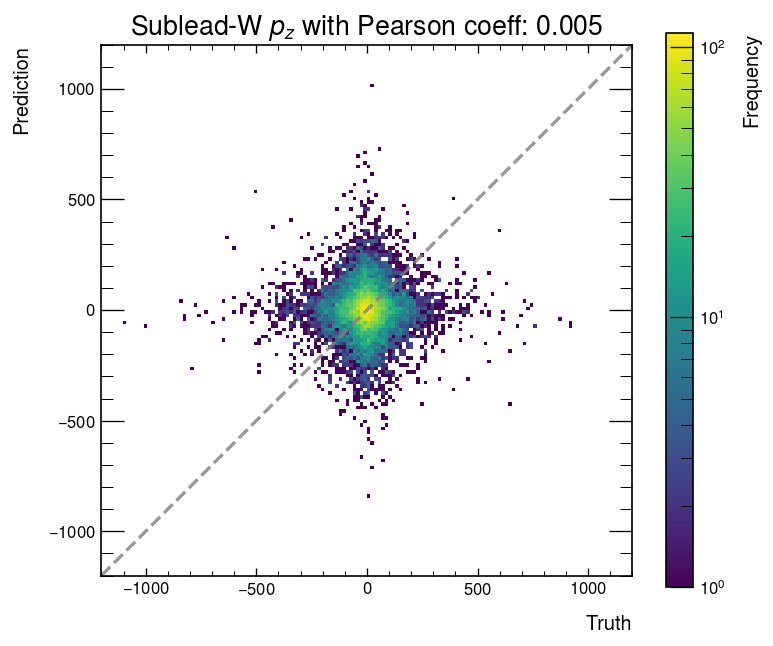

In [168]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,6]):.3f}, std: {np.std(sig_truth_inv[:,6]):.3f}, min: {np.min(sig_truth_inv[:,6]):.3f}, max: {np.max(sig_truth_inv[:,6]):.3f}"
)

set_range = [-1200, 1200]

plot.hist(
    data=[sig_truth_inv[:, 6], sig_pred_inv[:, 6]],
    label=r"$p_{z}^{W}$",
    title="Sublead-W $p_{z}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 6],
    sig_pred_inv[:, 6],
    r"Sublead-W $p_{z}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,6], sig_pred_inv[:,6])[0]:.3f}",
    range=set_range,
)

Truth mean: 160.774, std: 116.306, min: 32.625, max: 1729.237


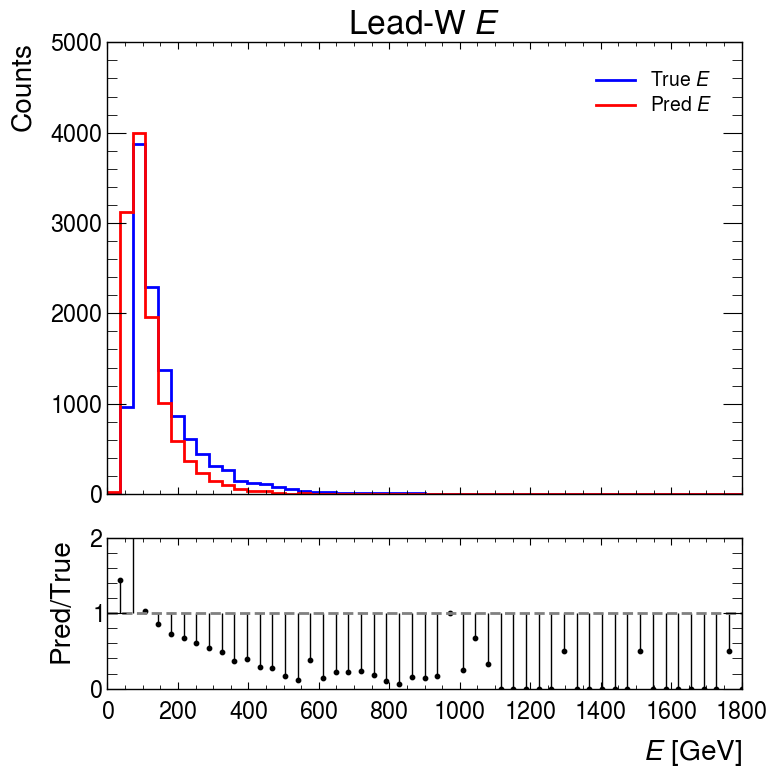

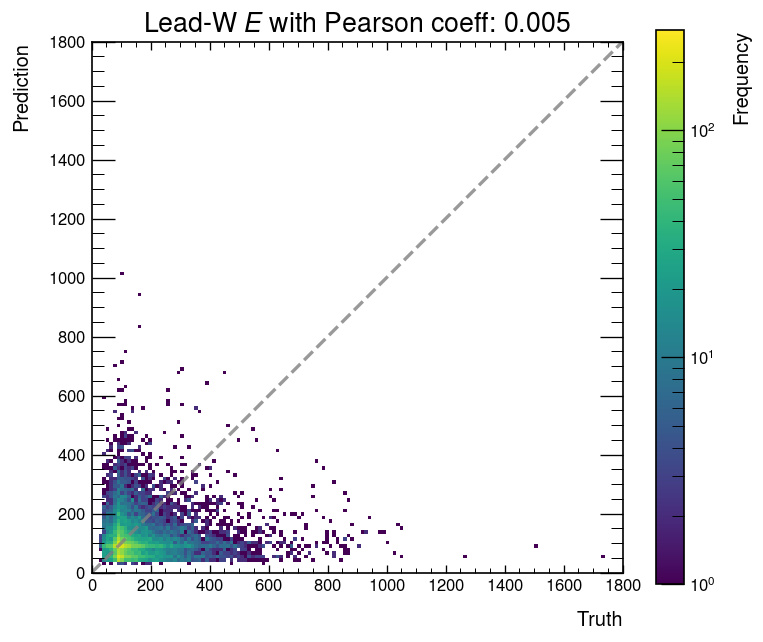

In [169]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 1800]

plot.hist(
    data=[sig_truth_inv[:, 3], sig_pred_inv[:, 3]],
    label=r"$E$",
    title="Lead-W $E$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 3],
    sig_pred_inv[:, 3],
    r"Lead-W $E$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,3], sig_pred_inv[:,3])[0]:.3f}",
    range=set_range,
)

Truth mean: 100.231, std: 82.065, min: 19.373, max: 1287.213


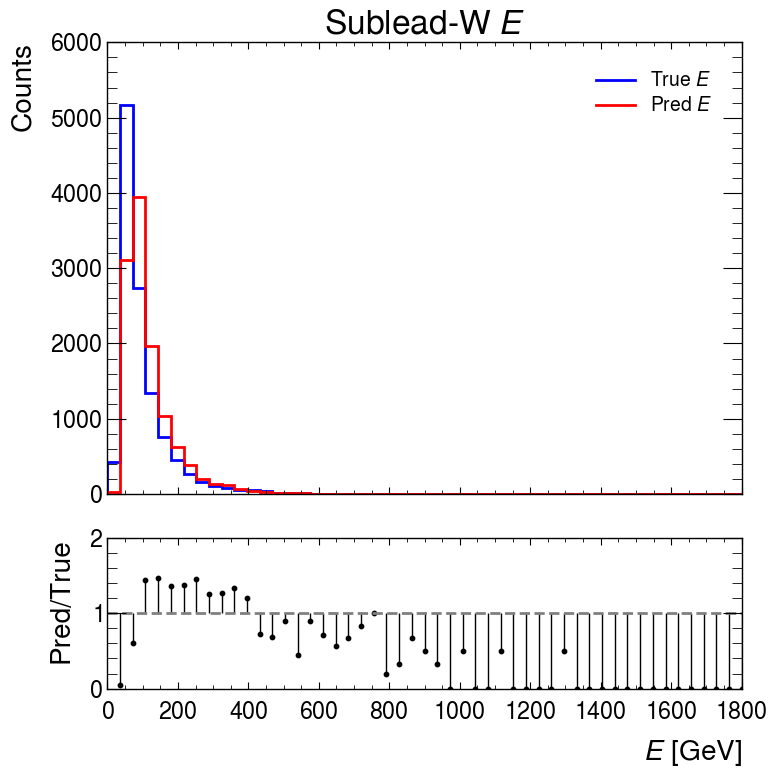

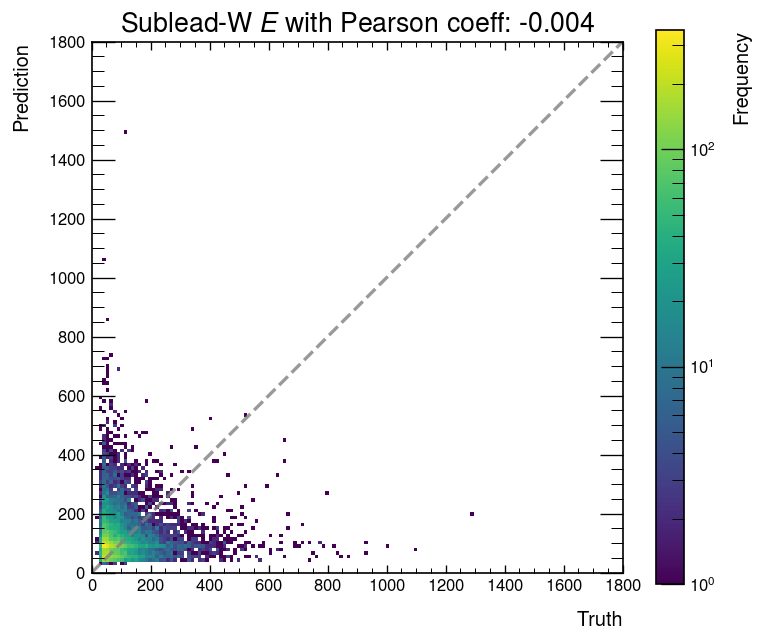

In [170]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,7]):.3f}, std: {np.std(sig_truth_inv[:,7]):.3f}, min: {np.min(sig_truth_inv[:,7]):.3f}, max: {np.max(sig_truth_inv[:,7]):.3f}"
)

set_range = [0, 1800]

plot.hist(
    data=[sig_truth_inv[:, 7], sig_pred_inv[:, 7]],
    label=r"$E$",
    title="Sublead-W $E$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 7],
    sig_pred_inv[:, 7],
    r"Sublead-W $E$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,7], sig_pred_inv[:,7])[0]:.3f}",
    range=set_range,
)

In [171]:
sig_pred_inv[1]

array([-16.884396 ,   6.5646243, 107.19916  , 133.70969  , -10.572502 ,
        39.89824  , 186.646    , 206.44955  ], dtype=float32)

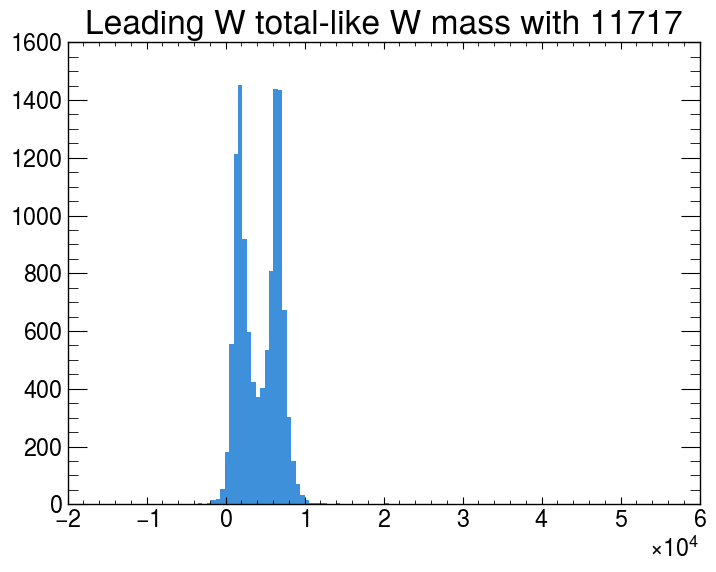

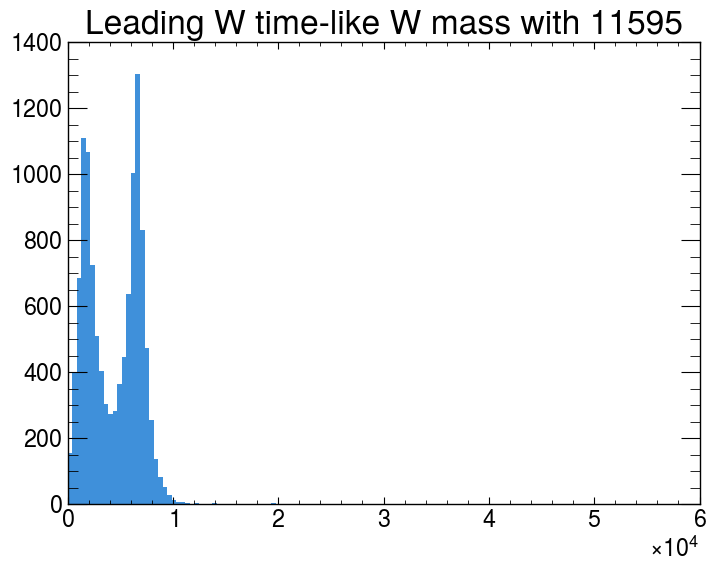

In [172]:
truth_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:3]), axis=1
)
truth_time_mask = truth_time_like >= 0
plt.hist(truth_time_like, bins=120, fill=True)
plt.title(f"Leading W total-like W mass with {len(truth_time_like)}")
plt.show()
plt.hist(truth_time_like[truth_time_mask], bins=120, fill=True)
plt.title(f"Leading W time-like W mass with {len(truth_time_like[truth_time_mask])}")
plt.show()

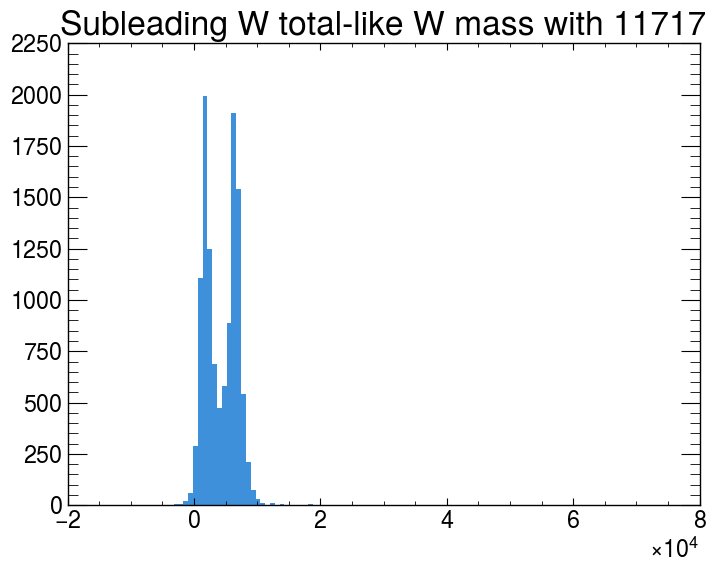

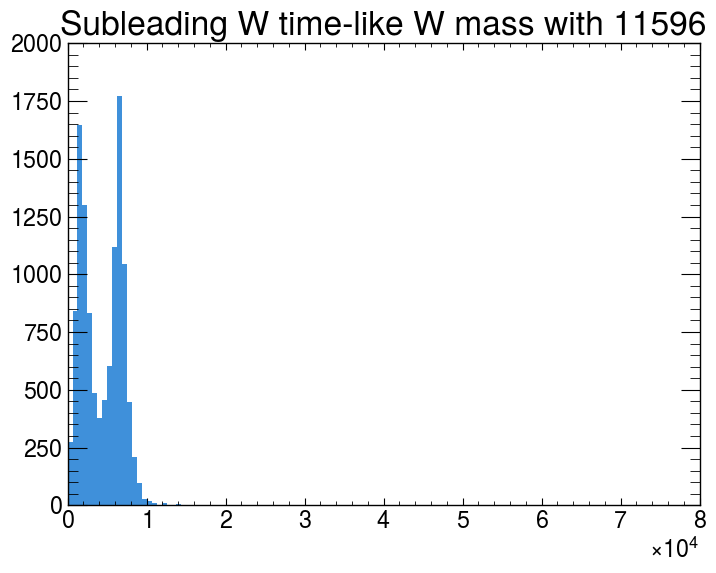

In [173]:
truth_time_like = np.square(sig_pred_inv[:, 7]) - np.sum(
    np.square(sig_pred_inv[:, 4:7]), axis=1
)
truth_time_mask = truth_time_like >= 0
plt.hist(truth_time_like, bins=120, fill=True)
plt.title(f"Subleading W total-like W mass with {len(truth_time_like)}")
plt.show()
plt.hist(truth_time_like[truth_time_mask], bins=120, fill=True)
plt.title(f"Subleading W time-like W mass with {len(truth_time_like[truth_time_mask])}")
plt.show()

In [174]:
# import shap
# import matplotlib as mpl

# mpl.rcParams.update(mpl.rcParamsDefault)

# feature_names = [
#     "lead_px",
#     "lead_py",
#     "lead_pz",
#     "lead_E",
#     "lead_pt",
#     "lead_eta",
#     "lead_phi",
#     "sublead_px",
#     "sublead_py",
#     "sublead_pz",
#     "sublead_E",
#     "sublead_pt",
#     "sublead_eta",
#     "sublead_phi",
#     "met_px",
#     "met_py",
#     "met_pt",
#     "met_phi",
#     "dilep_px",
#     "dilep_py",
#     "dilep_pz",
#     "dilep_E",
# 	"dilep_pt",
# 	"dilep_eta",
# 	"dilep_phi",
# ]
# title_name = [
#     "lead_px",
#     "lead_py",
#     "lead_pz",
#     "lead_E",
#     "sublead_px",
#     "sublead_py",
#     "sublead_pz",
#     "sublead_E",
# ]
# # lead
# # Use DeepExplainer for SHAP values
# explainer = shap.DeepExplainer(model, obs_kin[:512])
# explainer
# shap_values = explainer.shap_values(obs_kin[:512], check_additivity=False)
# for i in range(shap_values.shape[-1]):
#     plt.figure(figsize=(10, 6))
#     shap.summary_plot(
#         shap_values[:, :, i],
#         obs_kin[:512],
#         feature_names=feature_names,
#         plot_type="dot",
#         show=False,
#     )
#     plt.title(f"SHAP Summary Plot for W Regression Output: {title_name[i]}")
#     plt.show()

In [175]:
# validate by truth data

truth_lead_lep = Truth_lead_lep()
truth_sublead_lep = Truth_sublead_lep()
truth_met = Truth_met()

In [176]:
truth_obs_var = (
    np.column_stack(
        (
            truth_lead_lep.px,
            truth_lead_lep.py,
            truth_lead_lep.pz,
            truth_lead_lep.energy,
            truth_lead_lep.pt,
            truth_lead_lep.eta,
            truth_lead_lep.phi,
            truth_sublead_lep.px,
            truth_sublead_lep.py,
            truth_sublead_lep.pz,
            truth_sublead_lep.energy,
            truth_sublead_lep.pt,
            truth_sublead_lep.eta,
            truth_sublead_lep.phi,
            truth_met.px,
            truth_met.py,
            truth_met.pt,
            truth_met.phi,
            Truth_dilep.px,
            Truth_dilep.py,
            Truth_dilep.pz,
            Truth_dilep.energy,
            Truth_dilep.pt,
            Truth_dilep.eta,
            Truth_dilep.phi,
            Truth_dilep.m,
        ),
    )[PRE_CUT]
)[test_indices]

# truth labels
w_lead_truth_p4 = pd.DataFrame(w_lead.p4[PRE_CUT])
w_sublead_truth_p4 = pd.DataFrame(w_sublead.p4[PRE_CUT])

TRUTH_ROBUST_OBS = RobustScaler()
truth_obs_var = TRUTH_ROBUST_OBS.fit_transform(truth_obs_var)

In [177]:
truth_pred_int = model.predict(truth_obs_var)
truth_pred_int = np.concatenate([truth_pred_int[0], truth_pred_int[1]], axis=-1)

truth_pred_w_lead_px = truth_pred_int[:, 0]
truth_pred_w_lead_py = truth_pred_int[:, 1]
truth_pred_w_lead_pz = truth_pred_int[:, 2]
truth_pred_w_lead_energy = truth_pred_int[:, 3]
truth_pred_w_lead_p4 = np.vstack(
    [
        truth_pred_w_lead_px,
        truth_pred_w_lead_py,
        truth_pred_w_lead_pz,
        truth_pred_w_lead_energy,
    ]
).T
truth_pred_w_sublead_px = truth_pred_int[:, 4]
truth_pred_w_sublead_py = truth_pred_int[:, 5]
truth_pred_w_sublead_pz = truth_pred_int[:, 6]
truth_pred_w_sublead_energy = truth_pred_int[:, 7]
truth_pred_w_sublead_p4 = np.vstack(
    [
        truth_pred_w_sublead_px,
        truth_pred_w_sublead_py,
        truth_pred_w_sublead_pz,
        truth_pred_w_sublead_energy,
    ]
).T

 27/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


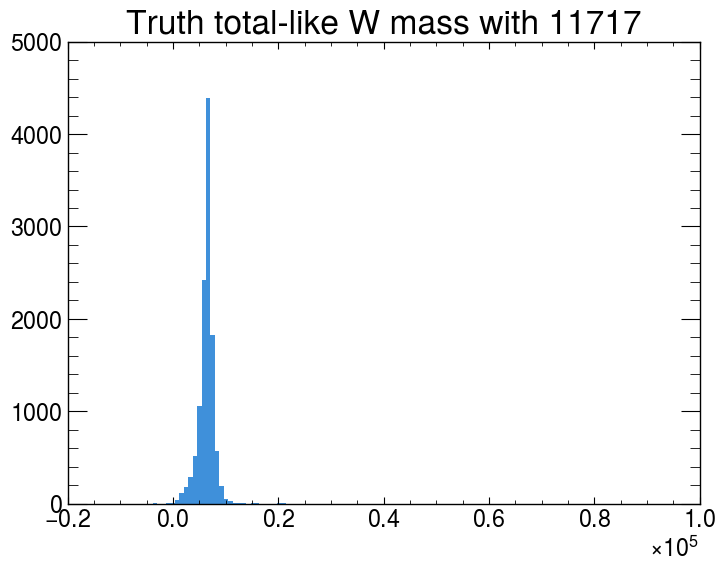

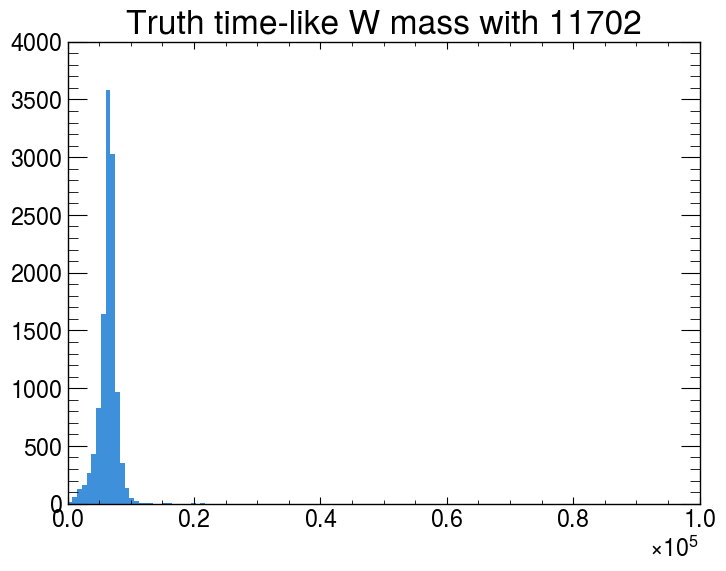

In [178]:
truth_time_like = np.square(truth_pred_w_lead_p4[:, 3]) - np.sum(
    np.square(truth_pred_w_lead_p4[:, 0:-1]), axis=1
)
truth_time_mask = truth_time_like > 0
plt.hist(truth_time_like, bins=120, fill=True)
plt.title(f"Truth total-like W mass with {len(truth_time_like)}")
plt.show()
plt.hist(truth_time_like[truth_time_mask], bins=120, fill=True)
plt.title(f"Truth time-like W mass with {len(truth_time_like[truth_time_mask])}")
plt.show()

In [179]:
truth_Bij = pd.read_hdf(data_path, "truth_Bij")


def der_org_plot(
    reco_data,
    truth_data,
    title="Bxy",
    raw_data=truth_Bij["Bxy"],
    unit="GeV",
    rmse=False,
    density=True,
):
    min_data = np.min([np.min(reco_data), np.min(truth_data), np.min(raw_data)])
    max_data = np.max([np.max(reco_data), np.max(truth_data), np.max(raw_data)])
    bin_edges = np.linspace(min_data, max_data, 81)
    plt.figure(figsize=(7, 5), dpi=100)
    hist = plt.hist(
        reco_data,
        density=density,
        bins=bin_edges,
        color="r",
        histtype="step",
        alpha=1,
        label="Reco",
    )
    hist = plt.hist(
        truth_data,
        density=density,
        bins=bin_edges,
        color="b",
        histtype="step",
        alpha=1,
        label="True",
    )
    if raw_data is not None:
        hist = plt.hist(
            raw_data,
            density=density,
            bins=bin_edges,
            color="grey",
            alpha=0.2,
            fill=True,
            label="label",
        )
    if unit is None:
        plt.xlabel("Null", fontsize=12)
    else:
        plt.xlabel(unit, fontsize=12)
    plt.ylabel("Norm. Count", fontsize=12)
    if rmse is True:
        plt.title(
            title
            + f" with RMSE: {np.sqrt(mean_squared_error(truth_data, reco_data)):.3f}",
            fontsize=16,
        )
    else:
        plt.title(title, fontsize=16)
    plt.legend()
    plt.show()
    plt.close()

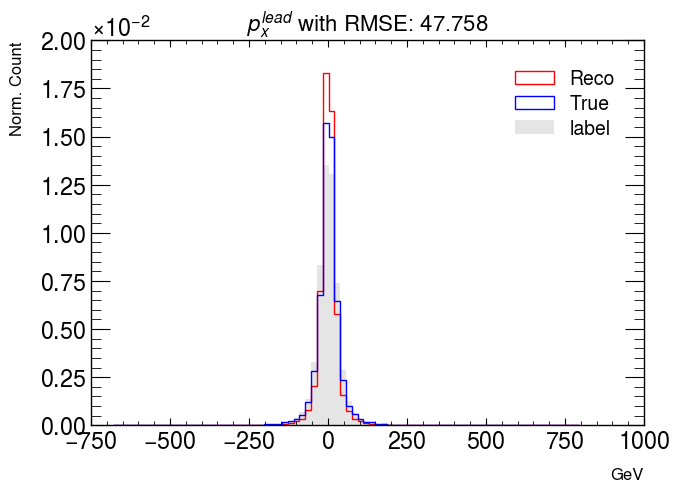

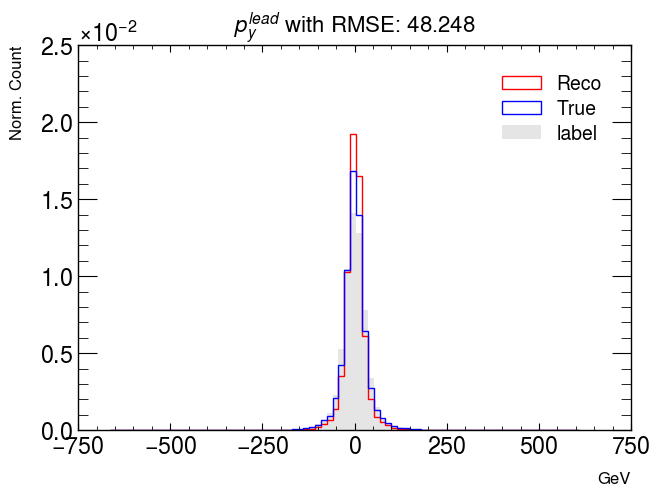

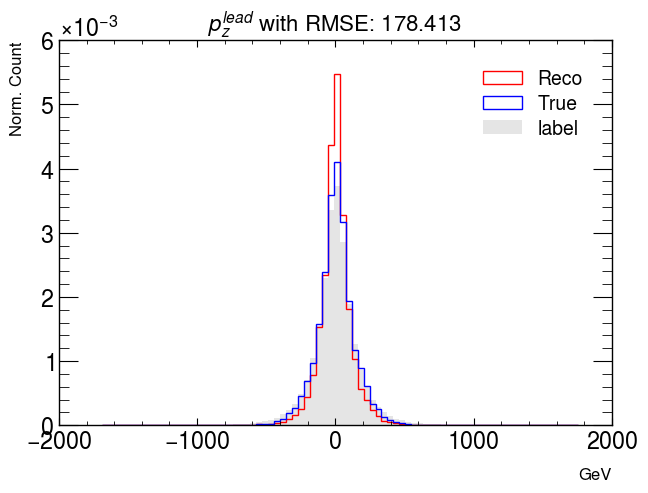

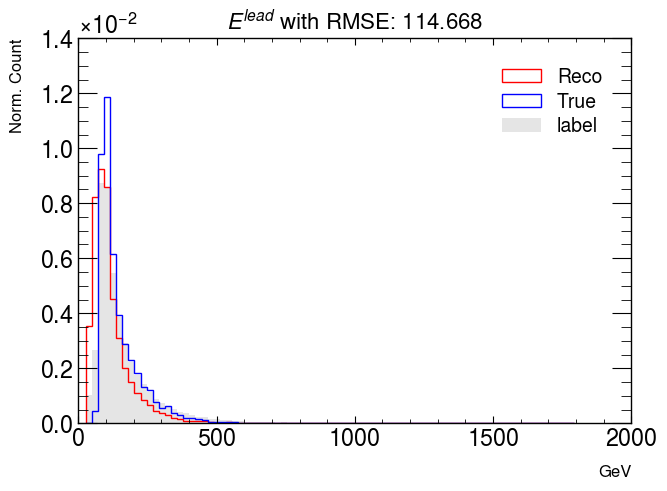

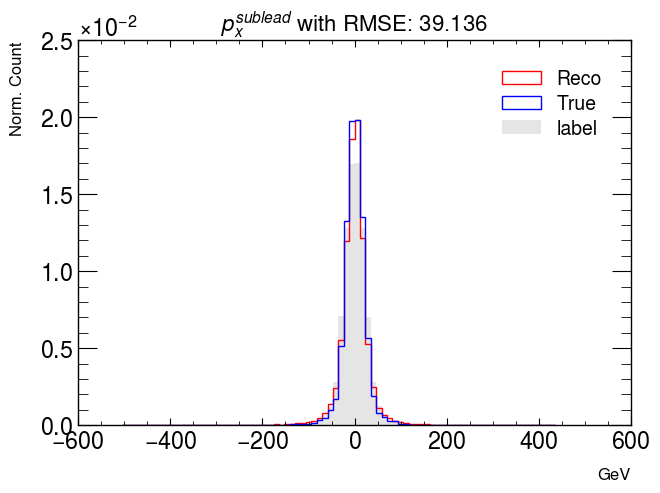

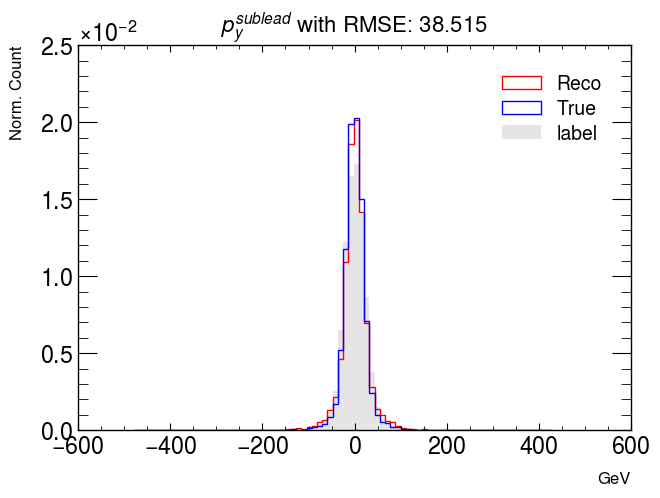

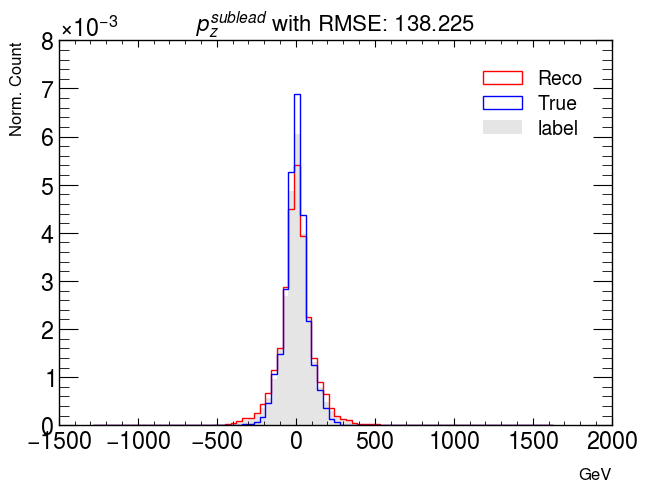

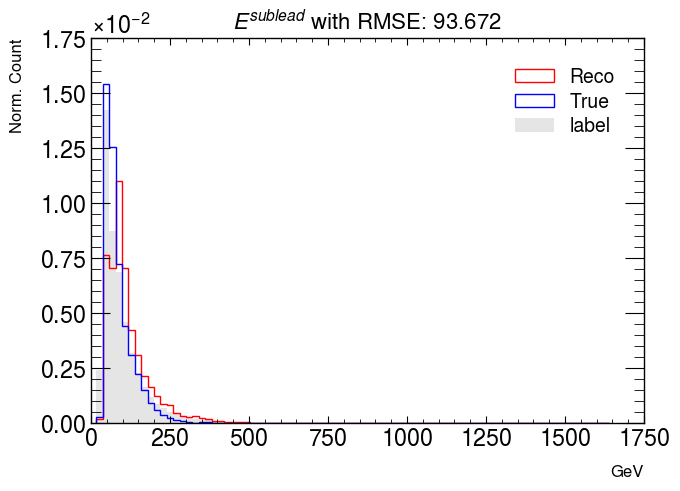

In [180]:
# lead
der_org_plot(
    sig_pred_inv[:, 0],
    truth_pred_w_lead_px,
    r"$p_{x}^{lead}$",
    raw_data=w_lead_truth_p4[0],
    rmse=True,
)
der_org_plot(
    sig_pred_inv[:, 1],
    truth_pred_w_lead_py,
    r"$p_{y}^{lead}$",
    raw_data=w_lead_truth_p4[1],
    rmse=True,
)
der_org_plot(
    sig_pred_inv[:, 2],
    truth_pred_w_lead_pz,
    r"$p_{z}^{lead}$",
    raw_data=w_lead_truth_p4[2],
    rmse=True,
)
der_org_plot(
    sig_pred_inv[:, 3],
    truth_pred_w_lead_energy,
    r"$E^{lead}$",
    raw_data=w_lead_truth_p4[3],
    rmse=True,
)

# sublead
der_org_plot(
    sig_pred_inv[:, 4],
    truth_pred_w_sublead_px,
    r"$p_{x}^{sublead}$",
    raw_data=w_sublead_truth_p4[0],
    rmse=True,
)
der_org_plot(
    sig_pred_inv[:, 5],
    truth_pred_w_sublead_py,
    r"$p_{y}^{sublead}$",
    raw_data=w_sublead_truth_p4[1],
    rmse=True,
)
der_org_plot(
    sig_pred_inv[:, 6],
    truth_pred_w_sublead_pz,
    r"$p_{z}^{sublead}$",
    raw_data=w_sublead_truth_p4[2],
    rmse=True,
)
der_org_plot(
    sig_pred_inv[:, 7],
    truth_pred_w_sublead_energy,
    r"$E^{sublead}$",
    raw_data=w_sublead_truth_p4[3],
    rmse=True,
)